## Weakly Supervised Localization : Class Activation map for mnist clutter
간단한 CNN (Global Average Pooling)을 mnist 데이터에 대해서 학습하고 임의의 mnist clutter 데이터 중 하나를 예측하고 Class Activation Map을 그리는 예제,  
**최성준 박사과정**의 아래의 코드를 참고하였음. mnist clutter 데이터는 기존의 mnist 데이터가 (28,28,1)의 image 였던 반면에, (40,40,1)의 image이며 아래의 그림과 같이 특정 숫자의 image에 대해서 noise가 섞여있는 이미지  

구조 : Conv-Conv-Max_pool-Conv-Conv-Global_average_pool-fully_connected  
(activation function으로 relu를 활용하며, relu를 통과하기전 batch normalization 활용)

* 참고코드
    1. https://github.com/sjchoi86/tensorflow-101/blob/master/notebooks/gap_mnist.ipynb  
    2. https://github.com/boseop/toy_example_of_Deep_learning_papers/blob/master/CAM%20for%20mnist.ipynb  
  
  
* 논문 : http://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Zhou_Learning_Deep_Features_CVPR_2016_paper.pdf

![Alt text](http://i.imgur.com/fTtJIFP.png)

### Load modules and mnist clutter data

In [1]:
import os, sys
import numpy as np
import tensorflow as tf
import matplotlib.pylab as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
from scipy.misc import imresize
from tensorflow.examples.tutorials.mnist import input_data
%matplotlib inline

In [2]:
mnist = np.load('./mnist_sequence1_sample_5distortions5x5.npz')

In [3]:
list(mnist)

['X_test', 'X_train', 'X_valid', 'y_valid', 'y_train', 'y_test']

In [4]:
tr_xs = mnist['X_train']
tr_ys = mnist['y_train']
val_xs = mnist['X_valid']
val_ys = mnist['y_valid']
ts_xs = mnist['X_test']
ts_ys = mnist['y_test']

In [5]:
# One-hot representation function
def one_hot(label):
    enc = OneHotEncoder()
    enc.fit(label)
    res = enc.transform(label).toarray()
    return res

In [6]:
# transform
tr_ys = one_hot(tr_ys)
val_ys = one_hot(val_ys)
ts_ys = one_hot(ts_ys)

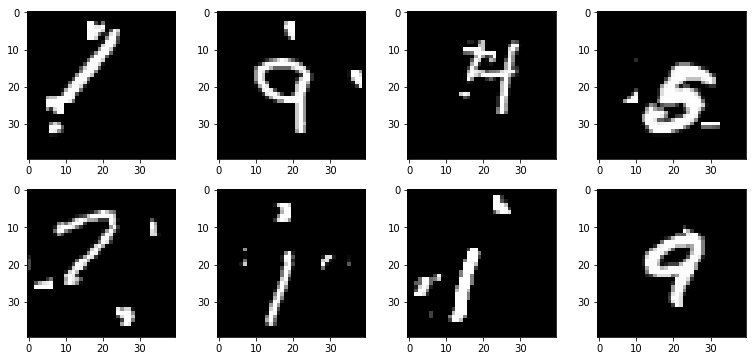

In [7]:
# Visualize mnist cluster dataset
tmp = tr_xs.reshape(-1,40,40)
indices = np.random.randint(0, high = tmp.shape[0], size = 8)
fig = plt.figure(figsize = (15,6))
fig.subplots_adjust(right=0.8)
for i, index in enumerate(indices):
    fig.add_subplot(2,4,i+1)
    plt.imshow(tmp[index], cmap = 'gray')    

### Define CNN

In [8]:
class CNN_with_gap:
    def __init__(self, sess):
        self.sess = sess
        self.build_net()
    # Generate a graph
    def build_net(self):
        with tf.variable_scope('weights'):
            self.weights = {
                'w1' : tf.get_variable(name = 'weight1', shape = [3,3,1,32],
                                       initializer = tf.contrib.layers.variance_scaling_initializer()), 
                'w2' : tf.get_variable(name = 'weight2', shape = [3,3,32,64],
                                       initializer = tf.contrib.layers.variance_scaling_initializer()),
                'w3' : tf.get_variable(name = 'weight3', shape = [3,3,64,96],
                                       initializer = tf.contrib.layers.variance_scaling_initializer()),
                'w4' : tf.get_variable(name = 'weight4', shape = [3,3,96,128],
                                       initializer = tf.contrib.layers.variance_scaling_initializer()),
                'w5' : tf.get_variable(name = 'weight5', shape = [128, 10],
                                       initializer = tf.contrib.layers.xavier_initializer())
            }
            
        with tf.variable_scope('bias'):
            self.bias = {
            'b1' : tf.get_variable(name = 'bias1', shape = [32], initializer = tf.random_uniform_initializer(minval = 0.001, maxval = 1)),
            'b2' : tf.get_variable(name = 'bias2', shape = [64], initializer = tf.random_uniform_initializer(minval = 0.001, maxval = 1)),
            'b3' : tf.get_variable(name = 'bias3', shape = [96], initializer = tf.random_uniform_initializer(minval = 0.001, maxval = 1)),
            'b4' : tf.get_variable(name = 'bias4', shape = [128], initializer = tf.random_uniform_initializer(minval = 0.001, maxval = 1)),
            'b5' : tf.get_variable(name = 'bias5', shape = [10], initializer = tf.random_normal_initializer())
            }
        
        self.X = tf.placeholder(dtype = tf.float32, shape = [None, 1600])
        self.Ximg = tf.reshape(tensor = self.X, shape = [-1, 40, 40, 1]) #reshape vector to image
        self.Y = tf.placeholder(dtype = tf.float32, shape = [None, 10])
        self.use_batch = tf.placeholder(dtype = tf.bool)
        self.learning_rate = tf.placeholder(dtype = tf.float32)

        with tf.variable_scope('conv_1'):
            conv1 = tf.nn.conv2d(input = self.Ximg, filter = self.weights['w1'], strides = [1,1,1,1], padding = 'SAME')
            pre_activation1 = conv1 + self.bias['b1']
            normalized_activation1 = tf.layers.batch_normalization(inputs=pre_activation1, training = self.use_batch, momentum = 0.9)
            relu1 = tf.nn.relu(features = normalized_activation1)
       
        with tf.variable_scope('conv_2'):
            conv2 = tf.nn.conv2d(input = relu1, filter = self.weights['w2'], strides = [1,1,1,1], padding = 'SAME')
            pre_activation2 = conv2 + self.bias['b2']
            normalized_activation2 = tf.layers.batch_normalization(inputs = pre_activation2, training = self.use_batch, momentum = 0.9)
            relu2 = tf.nn.relu(features = normalized_activation2)
            
        with tf.variable_scope('max_pool'):
            pooled = tf.nn.max_pool(value = relu2, ksize = [1,2,2,1], strides = [1,2,2,1], padding = 'SAME')
            
        with tf.variable_scope('conv_3'):    #conv_3
            conv3 = tf.nn.conv2d(input = pooled, filter = self.weights['w3'], strides = [1,1,1,1], padding = 'SAME')
            pre_activation3 = conv3 + self.bias['b3']
            normalized_activation3 = tf.layers.batch_normalization(inputs = pre_activation3, training = self.use_batch, momentum = 0.9)
            relu3 = tf.nn.relu(features = normalized_activation3)
            
        with tf.variable_scope('conv_4'): #conv_4
            conv4 = tf.nn.conv2d(input = relu3, filter = self.weights['w4'], strides = [1,1,1,1], padding = 'SAME')
            pre_activation4 = conv4 + self.bias['b4']
            normalized_activation4 = tf.layers.batch_normalization(inputs = pre_activation4, training = self.use_batch, momentum = 0.9)
            self.relu4 = tf.nn.relu(features = normalized_activation4)
            print(self.relu4)
        
        with tf.variable_scope('gap'):
            self.gap = tf.nn.avg_pool(value = self.relu4, ksize = [1,20,20,1], strides = [1,20,20,1], padding = 'SAME')
            self.gap_dense = tf.reshape(tensor = self.gap, shape = [-1,128])
    
        with tf.variable_scope('dense'):
            self.score = tf.matmul(self.gap_dense, self.weights['w5']) + self.bias['b5']
        
        with tf.variable_scope('loss'):
            self.loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels = self.Y, logits = self.score))
        
        self.updateOps = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
        
        with tf.variable_scope('train'):
            with tf.control_dependencies(self.updateOps):
                self.adam = tf.train.AdamOptimizer(self.learning_rate).minimize(self.loss)
            
    def train(self, x_data, y_data, learning_rate, use_batch):
        return self.sess.run([self.adam, self.loss], feed_dict = {self.X : x_data, self.Y : y_data,
                                                       self.learning_rate : learning_rate, self.use_batch : use_batch})
    
    def val_loss(self, x_data, y_data, use_batch):
        return self.sess.run(self.loss, feed_dict = {self.X : x_data, self.Y : y_data, self.use_batch : use_batch})
                     
    def predict(self, x_data, use_batch):
        return self.sess.run(self.score, feed_dict = {self.X : x_data, self.use_batch : use_batch})
    
    def Outforcam(self, x_data, use_batch):
        out = self.sess.run([self.Ximg, self.relu4, self.score, self.weights['w5']],
                             feed_dict = {self.X : x_data, self.use_batch : use_batch})
        output = {'Ximg' : out[0], 'relu4' : out[1], 'score' : out[2], 'dense_w' : out[3]}
        return output

### Parameter setting

In [9]:
# hyperparameter
batch_size = 100
epochs = 15
tr_loss_history = []
val_loss_history = []

# train
sess = tf.Session()
m1 = CNN_with_gap(sess)
sess.run(tf.global_variables_initializer())

Tensor("conv_4/Relu:0", shape=(?, 20, 20, 128), dtype=float32)


### Training 

In [10]:
for epoch in range(epochs):
    total_batch = int(tr_xs.shape[0] / batch_size)
    avg_tr_loss = 0
    avg_val_loss = 0
    
    for step in range(total_batch):
        batch_indices = np.random.choice(np.arange(tr_xs.shape[0]),size = batch_size , replace = False)
        batch_xs = tr_xs[batch_indices]
        batch_ys = tr_ys[batch_indices]
        _, tr_loss = m1.train(batch_xs, batch_ys, 1e-3, True)
        val_loss = m1.val_loss(val_xs, val_ys, False)
        avg_tr_loss += tr_loss / total_batch
        avg_val_loss += val_loss / total_batch

    tr_loss_history.append(avg_tr_loss)
    val_loss_history.append(avg_val_loss)        
    print('epoch : {:2}, tr_loss : {:.3f}, val_loss : {:.3f}'.format(epoch, avg_tr_loss, avg_val_loss))

epoch :  0, tr_loss : 1.668, val_loss : 1.950
epoch :  1, tr_loss : 0.737, val_loss : 0.807
epoch :  2, tr_loss : 0.420, val_loss : 0.524
epoch :  3, tr_loss : 0.270, val_loss : 0.387
epoch :  4, tr_loss : 0.212, val_loss : 0.350
epoch :  5, tr_loss : 0.161, val_loss : 0.296
epoch :  6, tr_loss : 0.133, val_loss : 0.393
epoch :  7, tr_loss : 0.112, val_loss : 0.348
epoch :  8, tr_loss : 0.092, val_loss : 0.286
epoch :  9, tr_loss : 0.082, val_loss : 0.360
epoch : 10, tr_loss : 0.070, val_loss : 0.365
epoch : 11, tr_loss : 0.056, val_loss : 0.327
epoch : 12, tr_loss : 0.050, val_loss : 0.323
epoch : 13, tr_loss : 0.044, val_loss : 0.469
epoch : 14, tr_loss : 0.039, val_loss : 0.316


### Performance 

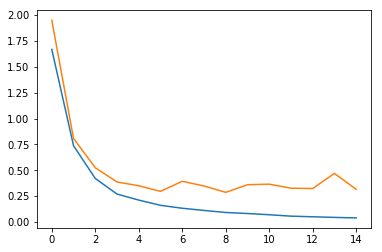

In [11]:
plt.plot(tr_loss_history)
plt.plot(val_loss_history)

In [12]:
test_result = []
for ts_row in range(ts_xs.shape[0]):
    tmp = m1.predict(ts_xs[ts_row].reshape(1,1600), use_batch = False)
    test_result.append(tmp)

In [13]:
iscorrect = np.equal(np.argmax(np.asarray(test_result).reshape(1000,10), axis = 1), np.argmax(ts_ys, axis = 1))
np.mean(iscorrect)

0.91400000000000003

### Class Activation Map

In [14]:
def minmax_scaler(arr):
    _arr = (arr - np.min(arr)) / (np.max(arr) - np.min(arr))
    return _arr

In [15]:
def cam(inputimg, label, outprob, camval, cweights):
    label_cate = {int(i) : str(i) for i in range(10)}
    fig = plt.figure(figsize = (15,6))
    fig.subplots_adjust(right=0.8)
    #plt.imshow(inputimg)
    #plt.title('True : {}'.format(label_cate.get(np.argmax(label))))
    for i in range(10):
        predweights = cweights[:, i:i + 1]
        camsum = np.zeros((20, 20))

        for j in range(128):
            camsum = camsum + predweights[j] * camval[0, :, :, j]
        camavg = camsum / 128

        fig.add_subplot(2, 5, i + 1)
        tmp = imresize(camavg, [40, 40], interp='bilinear')
        plt.imshow(minmax_scaler(tmp), cmap='jet', interpolation='bilinear')
        plt.title('prediction : {},\n prob : {:.3f}'.format(label_cate.get(i), outprob[0, i]))

In [16]:
num = np.random.randint(0, ts_xs.shape[0])
tmp = m1.Outforcam(ts_xs[num].reshape(1,1600), use_batch = False)
label = ts_ys[num]
inputimg = tmp.get('Ximg')
outprob = sess.run(tf.nn.softmax(tmp.get('score')))
camval = tmp.get('relu4')
cweights = tmp.get('dense_w')

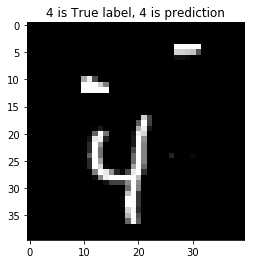

In [17]:
plt.imshow(ts_xs[num].reshape(40,40), cmap = 'gray')
plt.title('{} is True label, {} is prediction'.format(np.argmax(ts_ys[num]),np.argmax(outprob)))

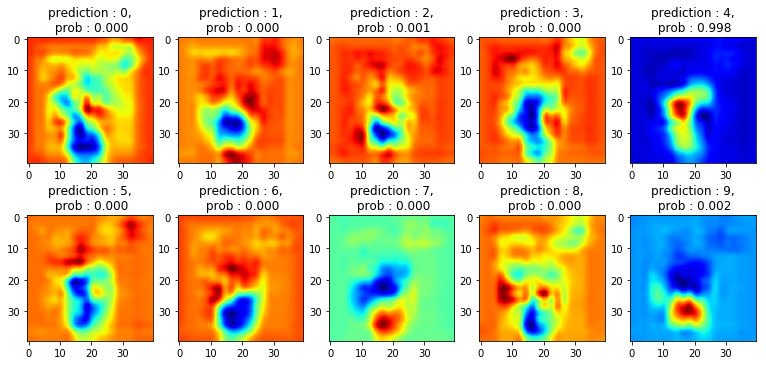

In [18]:
cam(inputimg, label, outprob, camval, cweights)